In [1]:
import random
import time
import copy
from collections import deque

import numpy as np

import torch as tc
import torch.nn as nn
import torch.optim as opt
import torch.distributions as tcdist
import torch.nn.functional as F

from model import SnakeNet
from core import CUDA_AVAILABLE, DEVICE
from config import NROW,NCOL
from env import Env
from util import state2input

class ChartWindow:
    def __init__(self,name):
        self.name=name
        self.data=deque(maxlen=1000)
        self.maxval=-9999
        self.minval=9999
    def add(self,x):
        self.data.append(x)
        self.maxval=max(self.maxval,x)
        self.minval=min(self.minval,x)
    def draw(self,ax):
        ax.plot(self.data)
        ax.plot([self.maxval]*len(self.data))
        ax.plot([self.minval]*len(self.data))
        ax.set_title(self.name)

In [2]:
#Train Parameters

BATCH_SIZE = 128
DISC_RATIO=0.93
GRADCLIP_NORM=10
L2_DECAY=0
LEARNING_RATE=1e-5
STAT_DISPLAY_FREQ = 10
SAVE_TEMP_FREQ = 50

In [3]:
import time as timelib
from PIL import Image
from PIL import ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display
def render(state,sleep_time=0,clear=True):
    #print(obs)
    txt = Image.new("RGBA", (NCOL*30,NROW*30), (10,50,100,100))
    draw = ImageDraw.Draw(txt)
    grid_size = 30
    for i in range(NROW):
        for j in range(NCOL):
            y1 = i*grid_size
            x1 = j*grid_size
            y2 = (i+1)*grid_size
            x2 = (j+1)*grid_size
            draw.rectangle(((x1, y1), (x2, y2)), outline='black', width=1)
    for y,x in state['foods']:
        draw.ellipse((x*grid_size, y*grid_size, (x+1)*grid_size, (y+1)*grid_size), fill = 'yellow', outline ='yellow')
    for y,x in state['snake']:
        if (y,x)==state['snake'][-1]:
            draw.polygon([((x+1/2)*grid_size,y*grid_size),(x*grid_size,(y+1/2)*grid_size),
                ((x+1/2)*grid_size,(y+1)*grid_size), ((x+1)*grid_size,(y+1/2)*grid_size)], fill = 'red')
        else:
            draw.rectangle(((x*grid_size, y*grid_size), ((x+1)*grid_size, (y+1)*grid_size)), fill='red', outline='red')
    txt = txt.resize((64, 64*NROW//NCOL)).convert('RGB')
    numpy_image = np.array(txt)
    plt.axis("off")
    trans1 = transforms.ToTensor()
    tensor_image = trans1(numpy_image)
    tf = transforms.ToPILImage()
    plt.imshow(tf(tensor_image))
    plt.show()
    plt.close()
    if sleep_time:
        timelib.sleep(sleep_time)
    if clear:
        display.clear_output(wait=True)
    return tensor_image

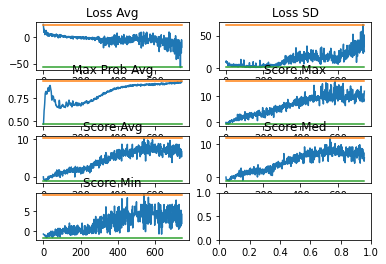

#7450: LossAvg=-57.754, LossSD=68.10, MaxprobAvg=0.931, ScoreMax=11.78, ScoreAvg=7.14, ScoreMed=6.62, ScoreMin=4.09
#7460: LossAvg=-56.123, LossSD=46.05, MaxprobAvg=0.927, ScoreMax=9.15, ScoreAvg=6.10, ScoreMed=6.37, ScoreMin=1.68


ValueError: The parameter probs has invalid values

In [4]:
net_from = input('load network from(esc to new network)')
net_to = input('save network to') or "test.w"

print("CUDA: ",CUDA_AVAILABLE)
net=SnakeNet().cuda() if CUDA_AVAILABLE else SnakeNet()
if net_from!='':
    net.load_state_dict(tc.load('./netw.pt'))
net.train()

opter=opt.Adam(net.parameters(),lr=LEARNING_RATE,weight_decay=L2_DECAY,eps=1e-4)
#opter=opt.RMSprop(net.parameters(),lr=LEARNING_RATE,eps=1e-4,momentum=0.9)
losses = []
scores = []
probmaxs = []

def train(bat):
    s1bat=tc.tensor([state2input(s1) for (s1,a,r,s2) in bat]).to(DEVICE)
    abat=tc.tensor([a for (s1,a,r,s2) in bat]).to(DEVICE)
    rbat=tc.tensor([r for (s1,a,r,s2) in bat]).to(DEVICE)
    s2bat=tc.tensor([state2input(s2) for (s1,a,r,s2) in bat]).to(DEVICE)
    dbat=tc.tensor([int(s2['done']) for (s1,a,r,s2) in bat]).to(DEVICE)

    td_target=rbat+DISC_RATIO*((1-dbat)*net.calcval(s2bat).squeeze())
    delta=td_target-net.calcval(s1bat).squeeze()

    polraw = net.calcpol(s1bat)
    pol_a = F.softmax(polraw,dim=1).gather(1,abat.unsqueeze(dim=1)).squeeze()
    loss_val = ((net.calcval(s1bat).squeeze()-td_target.detach())**2).sum()
    loss_pol = (-tc.log(pol_a) * delta.detach()).sum()
    loss_entropy = (F.log_softmax(polraw,dim=1)*F.softmax(polraw,dim=1)).sum()
    loss = loss_pol + 0.5*loss_val + 0.01*loss_entropy

    opter.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(net.parameters(),GRADCLIP_NORM)
    opter.step()
    
    losses.append(float(loss.mean()))

train_i=0
chart_lossavg=ChartWindow('Loss Avg')
chart_losssd=ChartWindow('Loss SD')
chart_maxprobavg=ChartWindow('Max Prob Avg')
chart_scoremax=ChartWindow('Score Max')
chart_scoreavg=ChartWindow('Score Avg')
chart_scoremed=ChartWindow('Score Med')
chart_scoremin=ChartWindow('Score Min')
f = open(net_to+'.train_info', "a")

def tmpsave():
    tc.save(net.state_dict(),net_to)
    display.clear_output(wait=True)
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,2)
    #plt.figure(figsize=(2,2),dpi=50)
    chart_lossavg.draw(ax1[0])
    chart_losssd.draw(ax1[1])
    chart_maxprobavg.draw(ax2[0])
    chart_scoremax.draw(ax2[1])
    chart_scoreavg.draw(ax3[0])
    chart_scoremed.draw(ax3[1])
    chart_scoremin.draw(ax4[0])
    plt.show()

def showinfo():
    lossavg = sum(losses)/len(losses) if losses else -1
    losssd = np.std(losses) if losses else -1
    maxprobavg = sum(probmaxs)/len(probmaxs) if probmaxs else -1
    scoremax = max(scores) if scores else -1
    scoreavg=sum(scores)/len(scores) if scores else -1
    scoremed=sorted(scores)[len(scores)//2] if scores else -1
    scoremin=sorted(scores)[0] if scores else -1
    print("#{}: LossAvg={:.3f}, LossSD={:.2f}, MaxprobAvg={:.3f}, ScoreMax={:.2f}, ScoreAvg={:.2f}, ScoreMed={:.2f}, ScoreMin={:.2f}"
        .format(train_i,lossavg,losssd,maxprobavg,scoremax,scoreavg,scoremed,scoremin))
    chart_lossavg.add(lossavg)
    chart_losssd.add(losssd)
    chart_maxprobavg.add(maxprobavg)
    chart_scoremax.add(scoremax)
    chart_scoreavg.add(scoreavg)
    chart_scoremed.add(scoremed)
    chart_scoremin.add(scoremin)
    print(lossavg,losssd,maxprobavg,scoremax,scoreavg,scoremed,scoremin,file=f)


envs = [Env(True) for _ in range(BATCH_SIZE)]
try:
    while True:
        train_i+=1
        batch = []
        for env in envs:
            s1=env.state
            if not s1 or s1['done']:
                scores.append(env.score)
                s1=env.reset()
            # if env==envs[0]:
            #     print(env.score)
            #     render(s1,0,True)
            pol = F.softmax(net.calcpol(tc.tensor(state2input(s1)).to(DEVICE)),dim=1)
            probmaxs.append(float(tc.max(pol)))
            a = tcdist.Categorical(pol).sample().item()
            s2,rwd=env.step(a)
            batch.append((s1,a,rwd,s2))
        train(batch)
        if train_i%SAVE_TEMP_FREQ==0:
            tmpsave()
        if train_i%STAT_DISPLAY_FREQ==0:
            showinfo()
            losses=[]
            probmaxs=[]
            scores=[]
except KeyboardInterrupt:
    tc.save(net.state_dict(),net_to)
    print("Saved to",net_to)
f.close()

In [ ]:
%debug

In [ ]:
learning rate가 1e4일때 nan가중치 생기는 문제있어서 1e5로 내렸더니 잘 된다.
이유가 뭘까? loss func의 log에 들어가는 수가 오차때문에 0또는 음수되서 그런듯. 버그 재현해서 losses마지막에 nan들어가있다면 확실(아마도 확인했던듯)
math.isnan(float(loss))체크해서 nan되기전에 loss가 먼저nan이면 더 확실
https://www.kdnuggets.com/2017/08/37-reasons-neural-network-not-working.html/2 의 항목37이 도움되는듯

loss가 nan이 되는게 아니라, loss표준편차를 보니 loss가 엄청 커져서 그렇다. 짐작으로는 수렴에 가까워져서 Adam의 momentum계산이 커져서 그런듯.
SGD로 바꿔보자. adam eps를 키워보면 되려나?
Adam학습속도 버릴수가 없다.
원래 과학습되면 이렇고, 그래서 RL도 조기종료(early stopping)를 아무튼 해야하긴 하는듯.

#TRAINCNT없애고 무한루프로 돌리자
#지나쳐도 알 수 있게 performance 저장하고 저장주기마다 차트출력하자. matplotlib으로 그리는게 맞을듯
#try catch로 keyboard exception만 잡아서 차트보여주고 훈련종료하게 하자
#훈련 나눠서 여러번 돌릴 수 있도록, 훈련시작하면 불러올 가중치경로와 저장할 가중치이름 입력받도록 하자
#가중치이름.info로 파일열어서 훈련정보 저장하도록 하자. 자동으로 버퍼 플러시 관리되니까 계속 출력하면 상관없을듯?